In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from datetime import datetime
import requests

In [3]:
# Define ticker symbols for the mutual funds
nippon = "0P00005WDS.BO"
hdfc = "0P0001NSWV.BO"
invesco = "0P0000XVHC.BO"
icici = "0P00005UO6.BO"
iti = "0P0001HCLR.BO"

# Download data
nippon_df = yf.download(nippon, start="2022-01-01", progress=False)
hdfc_df = yf.download(hdfc, start="2022-01-01", progress=False)
invesco_df = yf.download(invesco, start="2022-01-01", progress=False)
icici_df = yf.download(icici, start="2022-01-01", progress=False)
iti_df = yf.download(iti, start="2022-01-01", progress=False)

# Drop unwanted columns
columns_to_drop = ['High', 'Low', 'Open', 'Volume']

nippon_df = nippon_df.drop(columns=columns_to_drop)
hdfc_df = hdfc_df.drop(columns=columns_to_drop)
invesco_df = invesco_df.drop(columns=columns_to_drop)
icici_df = icici_df.drop(columns=columns_to_drop)
iti_df = iti_df.drop(columns=columns_to_drop)

YF.download() has changed argument auto_adjust default to True


In [4]:
nippon_df.reset_index(inplace=True)
hdfc_df.reset_index(inplace=True)
invesco_df.reset_index(inplace=True)
icici_df.reset_index(inplace=True)
iti_df.reset_index(inplace=True)


In [5]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
# 1️⃣ Prepare data
def prepare_data(df):
    data = df[['Date','Close']].copy().set_index('Date')
    scaler = MinMaxScaler((0,1))
    scaled = scaler.fit_transform(data[['Close']].astype('float32'))
    return data, scaler, scaled

nippon_data, nippon_scaler, nippon_scaled     = prepare_data(nippon_df)
hdfc_data,   hdfc_scaler,   hdfc_scaled       = prepare_data(hdfc_df)
invesco_data,invesco_scaler,invesco_scaled    = prepare_data(invesco_df)
icici_data,  icici_scaler,  icici_scaled      = prepare_data(icici_df)
iti_data,    iti_scaler,    iti_scaled        = prepare_data(iti_df)

# 2️⃣ Dataset builder
SEQ_LEN = 15
def create_dataset(series):
    X, y = [], []
    for i in range(SEQ_LEN, len(series)):
        X.append(series[i-SEQ_LEN:i,0])
        y.append(series[i,0])
    X = np.array(X, dtype='float32').reshape(-1, SEQ_LEN, 1)
    y = np.array(y, dtype='float32')
    return X, y

X_nippon, y_nippon     = create_dataset(nippon_scaled)
X_hdfc,   y_hdfc       = create_dataset(hdfc_scaled)
X_invesco,y_invesco    = create_dataset(invesco_scaled)
X_icici,  y_icici      = create_dataset(icici_scaled)
X_iti,    y_iti        = create_dataset(iti_scaled)

# 3️⃣ GPU-compatible LSTM builder
def build_model_gpu(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 4️⃣ Callbacks
def define_callbacks(name):
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ck = ModelCheckpoint(f'best_{name}.h5', monitor='val_loss', save_best_only=True, verbose=1)
    return [es, ck]

# 5️⃣ Train helper
def train_model_with_callbacks(model, X, y, name, epochs=50, batch_size=32):
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    callbacks = define_callbacks(name)
    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=epochs, batch_size=batch_size,
              callbacks=callbacks, verbose=2)
    return X_test, y_test



In [18]:
# 6️⃣ Build & Train all models
model_nippon   = build_model_gpu((SEQ_LEN, 1))
model_hdfc     = build_model_gpu((SEQ_LEN, 1))
model_invesco  = build_model_gpu((SEQ_LEN, 1))
model_icici    = build_model_gpu((SEQ_LEN, 1))
model_iti      = build_model_gpu((SEQ_LEN, 1))

Xn_t, yn_t = train_model_with_callbacks(model_nippon,   X_nippon,  y_nippon,  'nippon')
Xh_t, yh_t = train_model_with_callbacks(model_hdfc,     X_hdfc,    y_hdfc,    'hdfc')
Xi_t, yi_t = train_model_with_callbacks(model_invesco,  X_invesco, y_invesco, 'invesco')
Xc_t, yc_t = train_model_with_callbacks(model_icici,    X_icici,   y_icici,   'icici')
Xt_t, yt_t = train_model_with_callbacks(model_iti,      X_iti,     y_iti,     'iti')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.03422, saving model to best_nippon.h5


20/20 - 3s - 146ms/step - loss: 0.0545 - val_loss: 0.0342
Epoch 2/50

Epoch 2: val_loss improved from 0.03422 to 0.00237, saving model to best_nippon.h5


20/20 - 0s - 11ms/step - loss: 0.0070 - val_loss: 0.0024
Epoch 3/50

Epoch 3: val_loss did not improve from 0.00237
20/20 - 0s - 11ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 4/50

Epoch 4: val_loss did not improve from 0.00237
20/20 - 0s - 9ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 5/50

Epoch 5: val_loss improved from 0.00237 to 0.00188, saving model to best_nippon.h5


20/20 - 0s - 13ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 6/50

Epoch 6: val_loss improved from 0.00188 to 0.00187, saving model to best_nippon.h5


20/20 - 0s - 13ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 7/50

Epoch 7: val_loss improved from 0.00187 to 0.00169, saving model to best_nippon.h5


20/20 - 0s - 13ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/50

Epoch 8: val_loss improved from 0.00169 to 0.00166, saving model to best_nippon.h5


20/20 - 0s - 14ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/50

Epoch 9: val_loss improved from 0.00166 to 0.00147, saving model to best_nippon.h5


20/20 - 0s - 15ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 10/50

Epoch 10: val_loss did not improve from 0.00147
20/20 - 0s - 12ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/50

Epoch 11: val_loss did not improve from 0.00147
20/20 - 0s - 10ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 12/50

Epoch 12: val_loss improved from 0.00147 to 0.00145, saving model to best_nippon.h5


20/20 - 0s - 13ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 13/50

Epoch 13: val_loss did not improve from 0.00145
20/20 - 0s - 16ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 14/50

Epoch 14: val_loss improved from 0.00145 to 0.00143, saving model to best_nippon.h5


20/20 - 1s - 27ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 15/50

Epoch 15: val_loss did not improve from 0.00143
20/20 - 0s - 21ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 16/50

Epoch 16: val_loss did not improve from 0.00143
20/20 - 0s - 22ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 17/50

Epoch 17: val_loss did not improve from 0.00143
20/20 - 0s - 25ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 18/50

Epoch 18: val_loss improved from 0.00143 to 0.00142, saving model to best_nippon.h5


20/20 - 1s - 37ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 19/50

Epoch 19: val_loss did not improve from 0.00142
20/20 - 0s - 21ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 20/50

Epoch 20: val_loss did not improve from 0.00142
20/20 - 0s - 16ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 21/50

Epoch 21: val_loss did not improve from 0.00142
20/20 - 0s - 15ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 22/50

Epoch 22: val_loss did not improve from 0.00142
20/20 - 0s - 9ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 23/50

Epoch 23: val_loss improved from 0.00142 to 0.00139, saving model to best_nippon.h5


20/20 - 0s - 11ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 24/50

Epoch 24: val_loss did not improve from 0.00139
20/20 - 0s - 15ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 25/50

Epoch 25: val_loss did not improve from 0.00139
20/20 - 0s - 17ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 26/50

Epoch 26: val_loss did not improve from 0.00139
20/20 - 0s - 15ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 27/50

Epoch 27: val_loss did not improve from 0.00139
20/20 - 0s - 15ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 28/50

Epoch 28: val_loss did not improve from 0.00139
20/20 - 0s - 14ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 29/50

Epoch 29: val_loss improved from 0.00139 to 0.00137, saving model to best_nippon.h5


20/20 - 0s - 17ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 30/50

Epoch 30: val_loss did not improve from 0.00137
20/20 - 0s - 15ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 31/50

Epoch 31: val_loss did not improve from 0.00137
20/20 - 0s - 13ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 32/50

Epoch 32: val_loss did not improve from 0.00137
20/20 - 0s - 12ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 33/50

Epoch 33: val_loss did not improve from 0.00137
20/20 - 0s - 17ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 34/50

Epoch 34: val_loss did not improve from 0.00137
20/20 - 0s - 19ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 35/50

Epoch 35: val_loss did not improve from 0.00137
20/20 - 0s - 20ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 36/50

Epoch 36: val_loss did not improve from 0.00137
20/20 - 0s - 24ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 37/50

Epoch 37: val_loss did not improve from 0.00137
20/20 - 0s - 20ms/step - loss: 0.0017 - val_loss: 0.0027

20/20 - 2s - 112ms/step - loss: 0.0661 - val_loss: 0.0056
Epoch 2/50

Epoch 2: val_loss improved from 0.00561 to 0.00237, saving model to best_hdfc.h5


20/20 - 0s - 17ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 3/50

Epoch 3: val_loss improved from 0.00237 to 0.00220, saving model to best_hdfc.h5


20/20 - 0s - 14ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 4/50

Epoch 4: val_loss improved from 0.00220 to 0.00174, saving model to best_hdfc.h5


20/20 - 0s - 11ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 5/50

Epoch 5: val_loss did not improve from 0.00174
20/20 - 0s - 9ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 6/50

Epoch 6: val_loss did not improve from 0.00174
20/20 - 0s - 16ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/50

Epoch 7: val_loss improved from 0.00174 to 0.00164, saving model to best_hdfc.h5


20/20 - 0s - 16ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 8/50

Epoch 8: val_loss did not improve from 0.00164
20/20 - 0s - 10ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 9/50

Epoch 9: val_loss did not improve from 0.00164
20/20 - 0s - 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/50

Epoch 10: val_loss did not improve from 0.00164
20/20 - 0s - 15ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 11/50

Epoch 11: val_loss did not improve from 0.00164
20/20 - 0s - 16ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 12/50

Epoch 12: val_loss did not improve from 0.00164
20/20 - 0s - 15ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 13/50

Epoch 13: val_loss did not improve from 0.00164
20/20 - 0s - 16ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 14/50

Epoch 14: val_loss did not improve from 0.00164
20/20 - 0s - 14ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 15/50

Epoch 15: val_loss did not improve from 0.00164
20/20 - 0s - 15ms/step - loss: 0.0018 - val_loss: 0.0019
Epoc

20/20 - 3s - 143ms/step - loss: 0.0464 - val_loss: 0.0273
Epoch 2/50

Epoch 2: val_loss improved from 0.02730 to 0.00486, saving model to best_invesco.h5


20/20 - 0s - 15ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 3/50

Epoch 3: val_loss improved from 0.00486 to 0.00414, saving model to best_invesco.h5


20/20 - 0s - 15ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 4/50

Epoch 4: val_loss improved from 0.00414 to 0.00312, saving model to best_invesco.h5


20/20 - 0s - 17ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 5/50

Epoch 5: val_loss did not improve from 0.00312
20/20 - 0s - 10ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 6/50

Epoch 6: val_loss did not improve from 0.00312
20/20 - 0s - 11ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 7/50

Epoch 7: val_loss did not improve from 0.00312
20/20 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0078
Epoch 8/50

Epoch 8: val_loss did not improve from 0.00312
20/20 - 0s - 15ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 9/50

Epoch 9: val_loss did not improve from 0.00312
20/20 - 0s - 10ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 10/50

Epoch 10: val_loss improved from 0.00312 to 0.00309, saving model to best_invesco.h5


20/20 - 0s - 17ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 11/50

Epoch 11: val_loss did not improve from 0.00309
20/20 - 0s - 9ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 12/50

Epoch 12: val_loss improved from 0.00309 to 0.00286, saving model to best_invesco.h5


20/20 - 0s - 11ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 13/50

Epoch 13: val_loss did not improve from 0.00286
20/20 - 0s - 14ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 14/50

Epoch 14: val_loss did not improve from 0.00286
20/20 - 0s - 10ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 15/50

Epoch 15: val_loss improved from 0.00286 to 0.00257, saving model to best_invesco.h5


20/20 - 0s - 13ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 16/50

Epoch 16: val_loss did not improve from 0.00257
20/20 - 0s - 9ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 17/50

Epoch 17: val_loss did not improve from 0.00257
20/20 - 0s - 15ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 18/50

Epoch 18: val_loss did not improve from 0.00257
20/20 - 0s - 10ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 19/50

Epoch 19: val_loss did not improve from 0.00257
20/20 - 0s - 10ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 20/50

Epoch 20: val_loss did not improve from 0.00257
20/20 - 0s - 11ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 21/50

Epoch 21: val_loss improved from 0.00257 to 0.00250, saving model to best_invesco.h5


20/20 - 0s - 15ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 22/50

Epoch 22: val_loss did not improve from 0.00250
20/20 - 0s - 15ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 23/50

Epoch 23: val_loss did not improve from 0.00250
20/20 - 0s - 11ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 24/50

Epoch 24: val_loss did not improve from 0.00250
20/20 - 0s - 13ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 25/50

Epoch 25: val_loss did not improve from 0.00250
20/20 - 0s - 9ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 26/50

Epoch 26: val_loss improved from 0.00250 to 0.00234, saving model to best_invesco.h5


20/20 - 0s - 18ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 27/50

Epoch 27: val_loss improved from 0.00234 to 0.00222, saving model to best_invesco.h5


20/20 - 0s - 13ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 28/50

Epoch 28: val_loss did not improve from 0.00222
20/20 - 0s - 10ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 29/50

Epoch 29: val_loss did not improve from 0.00222
20/20 - 0s - 11ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 30/50

Epoch 30: val_loss improved from 0.00222 to 0.00221, saving model to best_invesco.h5


20/20 - 0s - 15ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 31/50

Epoch 31: val_loss did not improve from 0.00221
20/20 - 0s - 15ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 32/50

Epoch 32: val_loss did not improve from 0.00221
20/20 - 0s - 15ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 33/50

Epoch 33: val_loss did not improve from 0.00221
20/20 - 0s - 15ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 34/50

Epoch 34: val_loss did not improve from 0.00221
20/20 - 0s - 11ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 35/50

Epoch 35: val_loss did not improve from 0.00221
20/20 - 0s - 13ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 36/50

Epoch 36: val_loss did not improve from 0.00221
20/20 - 0s - 9ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 37/50

Epoch 37: val_loss did not improve from 0.00221
20/20 - 0s - 17ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 38/50

Epoch 38: val_loss did not improve from 0.00221
20/20 - 0s - 17ms/step - loss: 0.0013 - val_loss: 0.0022


20/20 - 0s - 16ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 40/50

Epoch 40: val_loss did not improve from 0.00207
20/20 - 0s - 14ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 41/50

Epoch 41: val_loss did not improve from 0.00207
20/20 - 0s - 13ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 42/50

Epoch 42: val_loss improved from 0.00207 to 0.00204, saving model to best_invesco.h5


20/20 - 0s - 16ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 43/50

Epoch 43: val_loss did not improve from 0.00204
20/20 - 0s - 13ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 44/50

Epoch 44: val_loss did not improve from 0.00204
20/20 - 0s - 15ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 45/50

Epoch 45: val_loss did not improve from 0.00204
20/20 - 0s - 12ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 46/50

Epoch 46: val_loss did not improve from 0.00204
20/20 - 0s - 11ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 47/50

Epoch 47: val_loss improved from 0.00204 to 0.00200, saving model to best_invesco.h5


20/20 - 0s - 15ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 48/50

Epoch 48: val_loss did not improve from 0.00200
20/20 - 0s - 11ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 49/50

Epoch 49: val_loss did not improve from 0.00200
20/20 - 0s - 14ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 50/50

Epoch 50: val_loss did not improve from 0.00200
20/20 - 0s - 10ms/step - loss: 0.0012 - val_loss: 0.0022
Restoring model weights from the end of the best epoch: 47.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.03331, saving model to best_icici.h5


20/20 - 2s - 114ms/step - loss: 0.0379 - val_loss: 0.0333
Epoch 2/50

Epoch 2: val_loss improved from 0.03331 to 0.00164, saving model to best_icici.h5


20/20 - 0s - 17ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 3/50

Epoch 3: val_loss improved from 0.00164 to 0.00138, saving model to best_icici.h5


20/20 - 0s - 11ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 4/50

Epoch 4: val_loss improved from 0.00138 to 0.00131, saving model to best_icici.h5


20/20 - 0s - 17ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 5/50

Epoch 5: val_loss did not improve from 0.00131
20/20 - 0s - 14ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 6/50

Epoch 6: val_loss improved from 0.00131 to 0.00131, saving model to best_icici.h5


20/20 - 0s - 11ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/50

Epoch 7: val_loss did not improve from 0.00131
20/20 - 0s - 11ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 8/50

Epoch 8: val_loss did not improve from 0.00131
20/20 - 0s - 9ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 9/50

Epoch 9: val_loss did not improve from 0.00131
20/20 - 0s - 11ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 10/50

Epoch 10: val_loss did not improve from 0.00131
20/20 - 0s - 11ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 11/50

Epoch 11: val_loss did not improve from 0.00131
20/20 - 0s - 13ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 12/50

Epoch 12: val_loss did not improve from 0.00131
20/20 - 0s - 17ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 13/50

Epoch 13: val_loss did not improve from 0.00131
20/20 - 0s - 13ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 14/50

Epoch 14: val_loss improved from 0.00131 to 0.00124, saving model to best_icici.h5


20/20 - 0s - 11ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 15/50

Epoch 15: val_loss did not improve from 0.00124
20/20 - 0s - 10ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 16/50

Epoch 16: val_loss did not improve from 0.00124
20/20 - 0s - 16ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 17/50

Epoch 17: val_loss did not improve from 0.00124
20/20 - 0s - 14ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 18/50

Epoch 18: val_loss did not improve from 0.00124
20/20 - 0s - 11ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 19/50

Epoch 19: val_loss improved from 0.00124 to 0.00122, saving model to best_icici.h5


20/20 - 0s - 11ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 20/50

Epoch 20: val_loss did not improve from 0.00122
20/20 - 0s - 11ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 21/50

Epoch 21: val_loss did not improve from 0.00122
20/20 - 0s - 11ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 22/50

Epoch 22: val_loss did not improve from 0.00122
20/20 - 0s - 15ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/50

Epoch 23: val_loss did not improve from 0.00122
20/20 - 0s - 13ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 24/50

Epoch 24: val_loss did not improve from 0.00122
20/20 - 0s - 10ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 25/50

Epoch 25: val_loss did not improve from 0.00122
20/20 - 0s - 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 26/50

Epoch 26: val_loss did not improve from 0.00122
20/20 - 0s - 19ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 27/50

Epoch 27: val_loss did not improve from 0.00122
20/20 - 0s - 15ms/step - loss: 0.0017 - val_loss: 0.0078

20/20 - 0s - 16ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 29/50

Epoch 29: val_loss did not improve from 0.00119
20/20 - 1s - 30ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 30/50

Epoch 30: val_loss improved from 0.00119 to 0.00116, saving model to best_icici.h5


20/20 - 0s - 16ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 31/50

Epoch 31: val_loss did not improve from 0.00116
20/20 - 0s - 9ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 32/50

Epoch 32: val_loss did not improve from 0.00116
20/20 - 0s - 10ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 33/50

Epoch 33: val_loss did not improve from 0.00116
20/20 - 0s - 11ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 34/50

Epoch 34: val_loss did not improve from 0.00116
20/20 - 0s - 13ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 35/50

Epoch 35: val_loss did not improve from 0.00116
20/20 - 0s - 16ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 36/50

Epoch 36: val_loss improved from 0.00116 to 0.00113, saving model to best_icici.h5


20/20 - 0s - 15ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 37/50

Epoch 37: val_loss did not improve from 0.00113
20/20 - 0s - 15ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 38/50

Epoch 38: val_loss did not improve from 0.00113
20/20 - 0s - 10ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 39/50

Epoch 39: val_loss did not improve from 0.00113
20/20 - 0s - 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 40/50

Epoch 40: val_loss did not improve from 0.00113
20/20 - 0s - 12ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 41/50

Epoch 41: val_loss did not improve from 0.00113
20/20 - 0s - 14ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 42/50

Epoch 42: val_loss improved from 0.00113 to 0.00111, saving model to best_icici.h5


20/20 - 0s - 11ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 43/50

Epoch 43: val_loss did not improve from 0.00111
20/20 - 0s - 9ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 44/50

Epoch 44: val_loss did not improve from 0.00111
20/20 - 0s - 10ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 45/50

Epoch 45: val_loss did not improve from 0.00111
20/20 - 0s - 11ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 46/50

Epoch 46: val_loss did not improve from 0.00111
20/20 - 0s - 9ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 47/50

Epoch 47: val_loss did not improve from 0.00111
20/20 - 0s - 11ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 48/50

Epoch 48: val_loss did not improve from 0.00111
20/20 - 0s - 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 49/50

Epoch 49: val_loss did not improve from 0.00111
20/20 - 0s - 15ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 50/50

Epoch 50: val_loss did not improve from 0.00111
20/20 - 0s - 11ms/step - loss: 0.0013 - val_loss: 0.0015
Re

20/20 - 2s - 117ms/step - loss: 0.0421 - val_loss: 0.0338
Epoch 2/50

Epoch 2: val_loss improved from 0.03378 to 0.00246, saving model to best_iti.h5


20/20 - 0s - 18ms/step - loss: 0.0069 - val_loss: 0.0025
Epoch 3/50

Epoch 3: val_loss did not improve from 0.00246
20/20 - 0s - 11ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/50

Epoch 4: val_loss improved from 0.00246 to 0.00234, saving model to best_iti.h5


20/20 - 0s - 17ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/50

Epoch 5: val_loss improved from 0.00234 to 0.00211, saving model to best_iti.h5


20/20 - 0s - 16ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/50

Epoch 6: val_loss did not improve from 0.00211
20/20 - 0s - 10ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 7/50

Epoch 7: val_loss did not improve from 0.00211
20/20 - 0s - 11ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 8/50

Epoch 8: val_loss did not improve from 0.00211
20/20 - 0s - 14ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 9/50

Epoch 9: val_loss improved from 0.00211 to 0.00205, saving model to best_iti.h5


20/20 - 0s - 17ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/50

Epoch 10: val_loss did not improve from 0.00205
20/20 - 0s - 10ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 11/50

Epoch 11: val_loss did not improve from 0.00205
20/20 - 0s - 10ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 12/50

Epoch 12: val_loss did not improve from 0.00205
20/20 - 0s - 20ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 13/50

Epoch 13: val_loss did not improve from 0.00205
20/20 - 1s - 31ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 14/50

Epoch 14: val_loss did not improve from 0.00205
20/20 - 1s - 31ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 15/50

Epoch 15: val_loss did not improve from 0.00205
20/20 - 0s - 12ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 16/50

Epoch 16: val_loss improved from 0.00205 to 0.00202, saving model to best_iti.h5


20/20 - 0s - 15ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 17/50

Epoch 17: val_loss did not improve from 0.00202
20/20 - 0s - 10ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 18/50

Epoch 18: val_loss did not improve from 0.00202
20/20 - 0s - 15ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 19/50

Epoch 19: val_loss did not improve from 0.00202
20/20 - 0s - 16ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 20/50

Epoch 20: val_loss improved from 0.00202 to 0.00200, saving model to best_iti.h5


20/20 - 0s - 12ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 21/50

Epoch 21: val_loss did not improve from 0.00200
20/20 - 0s - 15ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 22/50

Epoch 22: val_loss did not improve from 0.00200
20/20 - 0s - 15ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 23/50

Epoch 23: val_loss did not improve from 0.00200
20/20 - 0s - 13ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 24/50

Epoch 24: val_loss did not improve from 0.00200
20/20 - 0s - 12ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 25/50

Epoch 25: val_loss improved from 0.00200 to 0.00197, saving model to best_iti.h5


20/20 - 0s - 14ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 26/50

Epoch 26: val_loss did not improve from 0.00197
20/20 - 0s - 12ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 27/50

Epoch 27: val_loss did not improve from 0.00197
20/20 - 0s - 12ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 28/50

Epoch 28: val_loss did not improve from 0.00197
20/20 - 0s - 10ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 29/50

Epoch 29: val_loss improved from 0.00197 to 0.00196, saving model to best_iti.h5


20/20 - 0s - 12ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 30/50

Epoch 30: val_loss did not improve from 0.00196
20/20 - 0s - 12ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 31/50

Epoch 31: val_loss did not improve from 0.00196
20/20 - 0s - 10ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 32/50

Epoch 32: val_loss did not improve from 0.00196
20/20 - 0s - 16ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 33/50

Epoch 33: val_loss did not improve from 0.00196
20/20 - 0s - 11ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 34/50

Epoch 34: val_loss improved from 0.00196 to 0.00189, saving model to best_iti.h5


20/20 - 0s - 12ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 35/50

Epoch 35: val_loss did not improve from 0.00189
20/20 - 0s - 14ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 36/50

Epoch 36: val_loss did not improve from 0.00189
20/20 - 0s - 15ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 37/50

Epoch 37: val_loss did not improve from 0.00189
20/20 - 0s - 13ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 38/50

Epoch 38: val_loss did not improve from 0.00189
20/20 - 0s - 17ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 39/50

Epoch 39: val_loss did not improve from 0.00189
20/20 - 0s - 10ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 40/50

Epoch 40: val_loss improved from 0.00189 to 0.00185, saving model to best_iti.h5


20/20 - 0s - 12ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 41/50

Epoch 41: val_loss improved from 0.00185 to 0.00183, saving model to best_iti.h5


20/20 - 0s - 16ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 42/50

Epoch 42: val_loss did not improve from 0.00183
20/20 - 0s - 12ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 43/50

Epoch 43: val_loss did not improve from 0.00183
20/20 - 0s - 16ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 44/50

Epoch 44: val_loss did not improve from 0.00183
20/20 - 0s - 14ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 45/50

Epoch 45: val_loss did not improve from 0.00183
20/20 - 0s - 17ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 46/50

Epoch 46: val_loss did not improve from 0.00183
20/20 - 0s - 10ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 47/50

Epoch 47: val_loss did not improve from 0.00183
20/20 - 0s - 12ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 48/50

Epoch 48: val_loss did not improve from 0.00183
20/20 - 0s - 15ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 49/50

Epoch 49: val_loss did not improve from 0.00183
20/20 - 0s - 12ms/step - loss: 0.0016 - val_loss: 0.0024

In [19]:
# 7️⃣ Predict, Invert Scale, MAPE
def predict_and_evaluate(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
    return y_test_inv, y_pred_inv, mape

results = {}
results['Nippon']  = predict_and_evaluate(model_nippon,  Xn_t, yn_t, nippon_scaler)
results['HDFC']    = predict_and_evaluate(model_hdfc,    Xh_t, yh_t, hdfc_scaler)
results['Invesco'] = predict_and_evaluate(model_invesco, Xi_t, yi_t, invesco_scaler)
results['ICICI']   = predict_and_evaluate(model_icici,   Xc_t, yc_t, icici_scaler)
results['ITI']     = predict_and_evaluate(model_iti,     Xt_t, yt_t, iti_scaler)



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


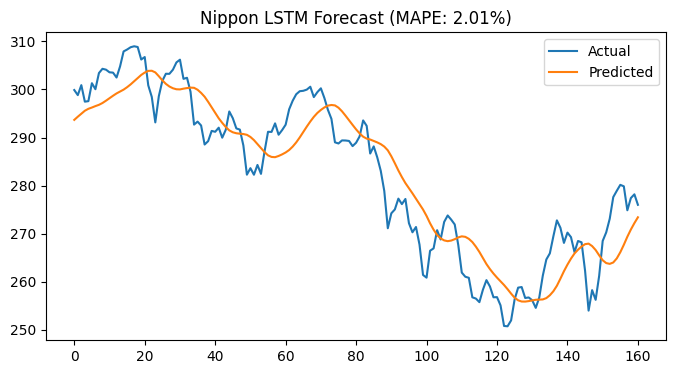

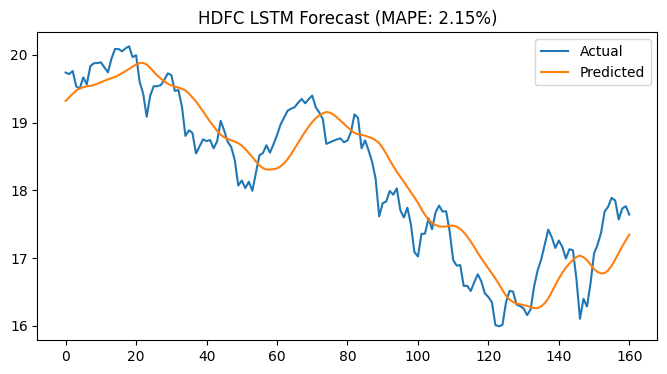

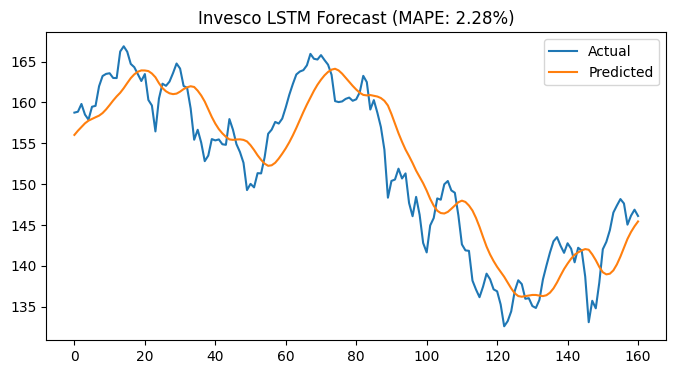

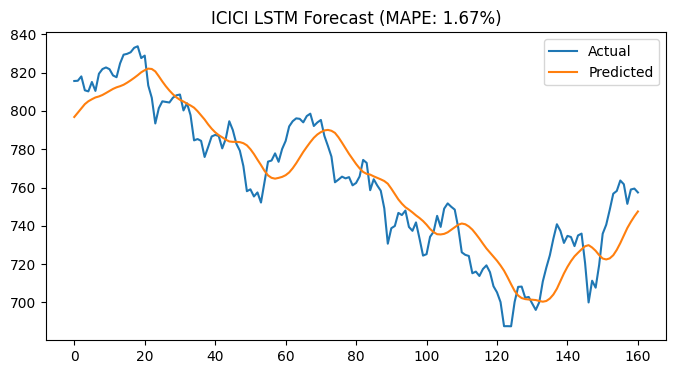

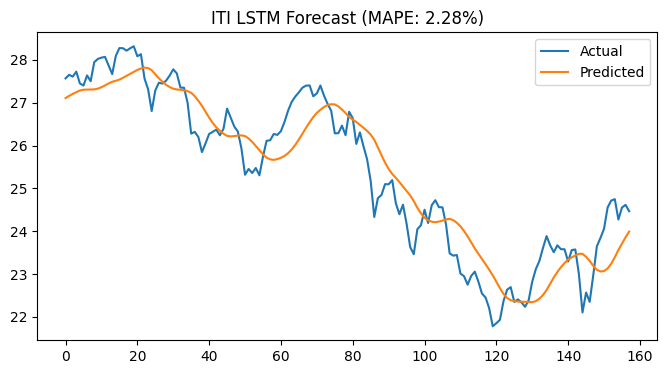

In [20]:
# 8️⃣ Plot predictions
for name, (actual, pred, mape) in results.items():
    plt.figure(figsize=(8,4))
    plt.plot(actual, label='Actual')
    plt.plot(pred,   label='Predicted')
    plt.title(f'{name} LSTM Forecast (MAPE: {mape:.2f}%)')
    plt.legend()
    plt.show()

In [21]:
# 9️⃣ Print MAPE values
for name, (actual, pred, mape) in results.items():
    print(f'{name} Model MAPE: {mape:.2f}%')


Nippon Model MAPE: 2.01%
HDFC Model MAPE: 2.15%
Invesco Model MAPE: 2.28%
ICICI Model MAPE: 1.67%
ITI Model MAPE: 2.28%


In [22]:
# Ensure that the Date column is in datetime format
nippon_data['Date'] = pd.to_datetime(nippon_data.index)
hdfc_data['Date'] = pd.to_datetime(hdfc_data.index)
invesco_data['Date'] = pd.to_datetime(invesco_data.index)
icici_data['Date'] = pd.to_datetime(icici_data.index)
iti_data['Date'] = pd.to_datetime(iti_data.index)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

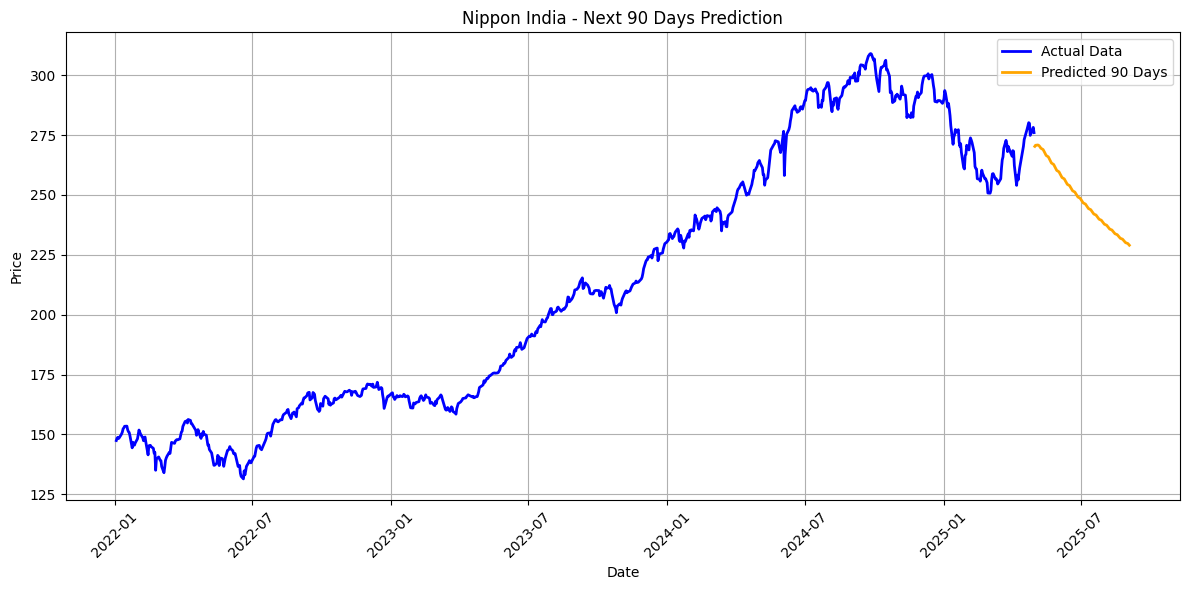

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def predict_next_90_days(model, data_scaled, scaler, seq_len=90):
    # Start with the last 'seq_len' days of data
    last_sequence = data_scaled[-seq_len:]
    predictions = []

    for _ in range(90):  # Predict the next 90 days
        # Reshape and predict the next value
        input_seq = last_sequence.reshape(1, seq_len, 1)
        next_value = model.predict(input_seq)
        predictions.append(next_value[0,0])

        # Append the predicted value to the sequence for the next prediction
        last_sequence = np.append(last_sequence[1:], next_value, axis=0)

    # Invert scaling of the predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions_inv

def plot_predictions(actual_data, predictions, company_name):
    plt.figure(figsize=(12, 6))

    # Plot actual data
    plt.plot(actual_data['Date'], actual_data['Close'], label='Actual Data', color='blue', linewidth=2)

    # Create future dates for the next 90 days
    future_dates = pd.date_range(actual_data['Date'].iloc[-1], periods=91, freq='B')[1:]

    # Plot predicted values as a continuous line
    plt.plot(future_dates, predictions, label='Predicted 90 Days', color='orange', linestyle='-', linewidth=2)

    # Set labels and title
    plt.title(f'{company_name} - Next 90 Days Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()  # Ensure everything fits without overlapping
    plt.show()

# Predict the next 90 days for all models
predictions_nippon = predict_next_90_days(model_nippon, nippon_scaled, nippon_scaler)
predictions_hdfc = predict_next_90_days(model_hdfc, hdfc_scaled, hdfc_scaler)
predictions_invesco = predict_next_90_days(model_invesco, invesco_scaled, invesco_scaler)
predictions_icici = predict_next_90_days(model_icici, icici_scaled, icici_scaler)
predictions_iti = predict_next_90_days(model_iti, iti_scaled, iti_scaler)

# Visualize predictions for each company
plot_predictions(nippon_data, predictions_nippon, 'Nippon India')



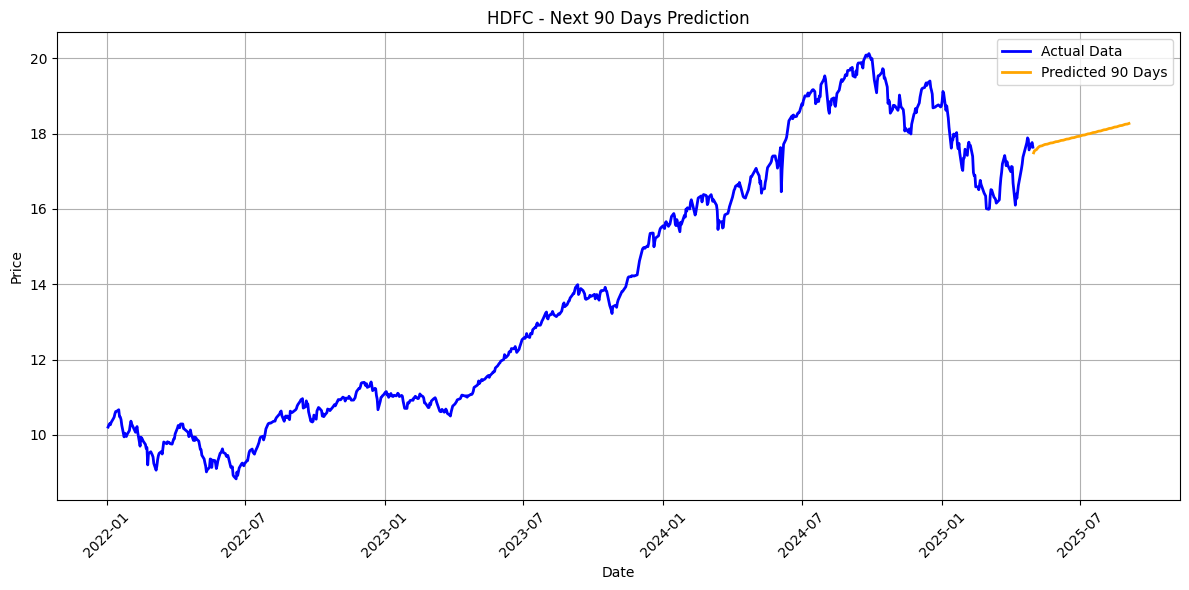

In [24]:
plot_predictions(hdfc_data, predictions_hdfc, 'HDFC')


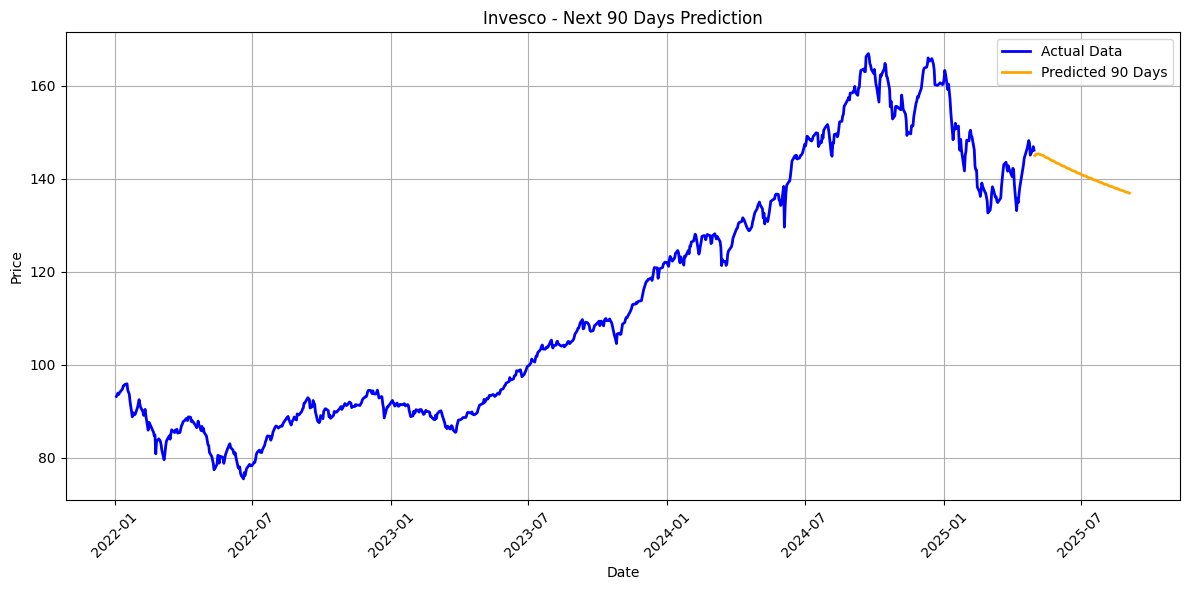

In [25]:
plot_predictions(invesco_data, predictions_invesco, 'Invesco')


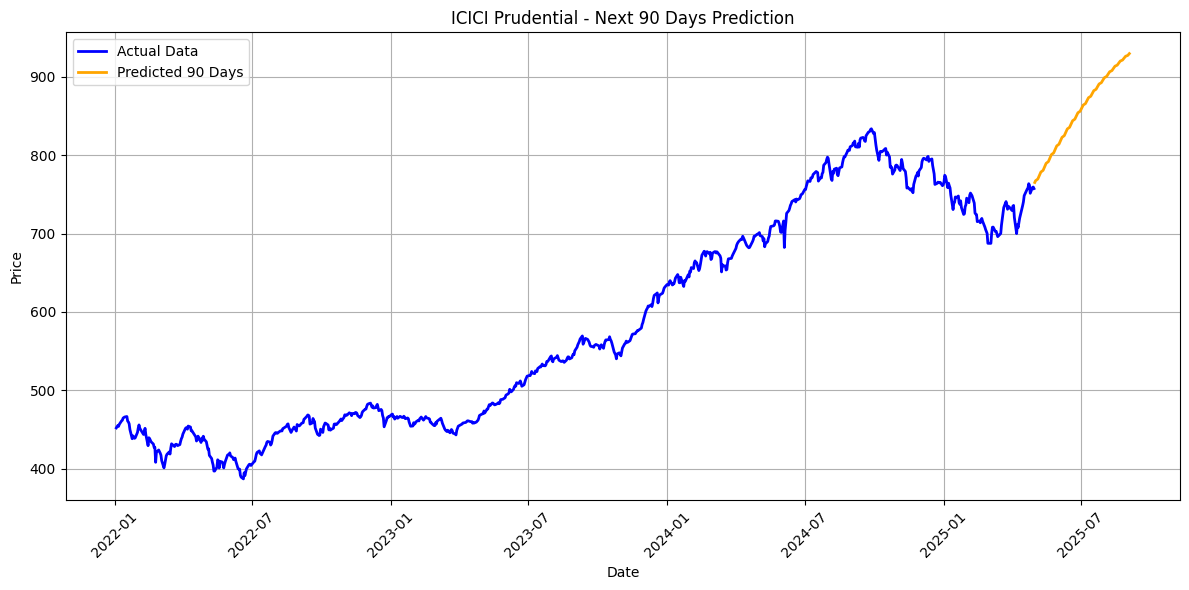

In [26]:
plot_predictions(icici_data, predictions_icici, 'ICICI Prudential')


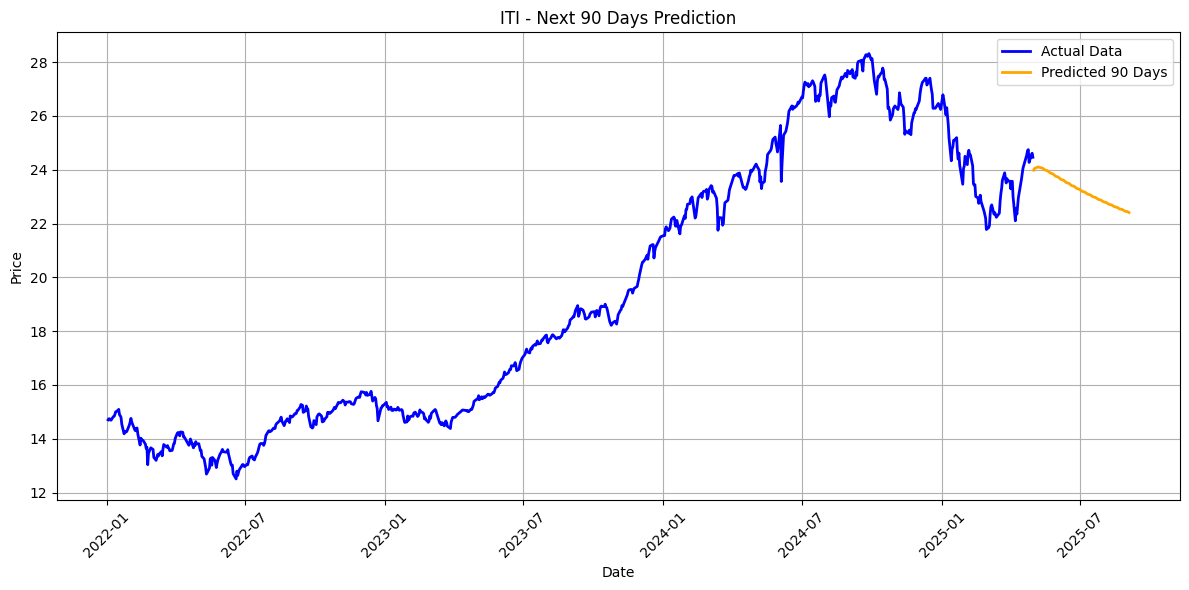

In [27]:
plot_predictions(iti_data, predictions_iti, 'ITI')